## Historic Drought Analysis

This notebook steps through an analysis of droughts in the DRB, assessing droughts using multiple different metrics including:
- Exceedance probability
- Severity
- Duration

Droughts are classified using the Standardized Streamflow Index (SSI).

In [52]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as scs

import spei as si

from utils.drought_plots import plot_ssi

# Directory to pywrdrb project
pywrdrb_directory = '../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches

In [53]:
# Model generation specifications
full_date_range = ('1945-01-01', '2022-12-31')

# Constants
cms_to_mgd = 22.82
fdc_quantiles = [0.0003, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.995, 0.9997]

In [54]:
Q_reconst = pd.read_csv(f'./outputs/historic_reconstruction_daily_nhmv10_mgd.csv', sep = ',', index_col = 0, parse_dates = True)
nyc_reservoirs = ['cannonsville', 'pepacton', 'neversink']

# Q_reconst = Q_reconst.loc[:'1970-01-01',:]
# Sum inflows by node
Q_reconst_nodes = pd.DataFrame(index=Q_reconst.index, columns=obs_pub_site_matches.keys())
for node in Q_reconst_nodes.columns:
    if obs_pub_site_matches[node] is not None:
        Q_reconst_nodes.loc[:,node] = Q_reconst.loc[:, obs_pub_site_matches[node]].sum(axis=1)
    else:
        Q_reconst_nodes.loc[:,node] = Q_reconst.loc[:, node]
Q_reconst_nodes["Total NYC Inflow"] = Q_reconst_nodes.loc[:,nyc_reservoirs].sum(axis=1)
Q_reconst_nodes["Basin Total"] = Q_reconst_nodes.sum(axis=1)

In [55]:
Q_reconst['delTrenton'].max()


107910.66123813493

In [87]:
# Rolling sum
consider_nodes = ['pepacton', 'Total NYC Inflow', 'Basin Total']
Q_rsum = Q_reconst.rolling("365D").sum().dropna()
Q_nodes_rsum = Q_reconst_nodes.rolling("365D").sum().dropna()

node_ssi = pd.DataFrame(index = Q_rsum.index, columns=consider_nodes)
for node in node_ssi.columns:
    node_ssi[node] = si.ssfi(Q_nodes_rsum[node], dist = scs.gamma)

node_ssi = node_ssi.loc['1946-01-01':,:]

# cannonsville_gammfit_plot = si.plot.dist(Q_nodes_rsum['cannonsville'], scs.gamma, cumulative=True, legend = False)

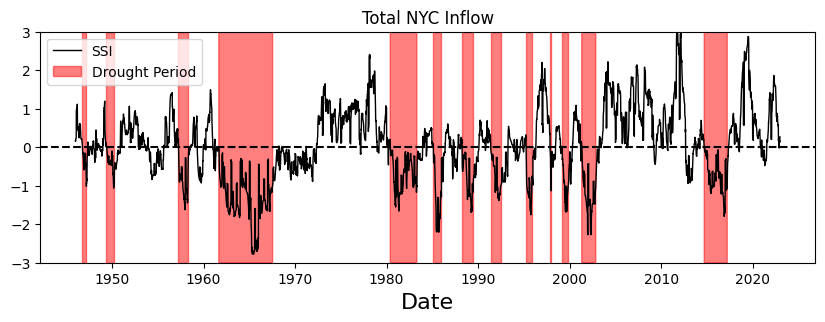

In [88]:
plot_nodes = ['Total NYC Inflow']
# plot_nodes = ['pepacton']

fig, ax = plt.subplots(nrows=len(plot_nodes), ncols=1, figsize = (10,len(plot_nodes)*3), sharex = True)
plot_ssi(node_ssi[plot_nodes[0]], ax = ax)
ax.set_title(plot_nodes[0])
plt.xlabel('Date', fontsize=16)
# plt.ylabel('SSI', fontsize=16)
plt.legend(loc='upper left')

In [91]:

drought_data = {}
drought_counter = 0
for node in plot_nodes:
    ssi = node_ssi[node]
    in_drought = False
    in_critical_drought = False

    drought_days = []

    for ind in range(len(ssi)):
        if ssi.values[ind] < 0:
            in_drought = True
            drought_days.append(ind)
            
            if ssi.values[ind] <= -1:
                in_critical_drought = True
        else:
            # Record drought info once it ends
            if in_critical_drought:
                drought_counter += 1
                drought_data[drought_counter] = {
                    'start':ssi.index[drought_days[0]],
                    'end': ssi.index[drought_days[-1]],
                    'duration': len(drought_days),
                    'magnitude': sum(ssi.values[drought_days]),
                    'severity': min(ssi.values[drought_days]),
                    'node': node
                }
                
            in_drought = False
            in_critical_drought = False
            drought_days = [] 

drought_metrics = pd.DataFrame(drought_data).transpose()
# drought_metrics = drought_metrics.drop(1, axis=0).reset_index()
drought_metrics


,start,end,duration,magnitude,severity,node
1,1946-10-09,1947-05-06,210,-86.422592,-1.01175,Total NYC Inflow
2,1949-05-24,1950-11-25,551,-198.999241,-1.062474,Total NYC Inflow
3,1957-04-06,1958-07-31,482,-363.817215,-1.622949,Total NYC Inflow
4,1961-09-01,1968-03-24,2397,-3046.468287,-2.774912,Total NYC Inflow
5,1980-05-28,1983-12-13,1295,-804.674315,-1.658867,Total NYC Inflow
6,1985-02-14,1986-05-23,464,-514.644319,-2.201678,Total NYC Inflow
7,1988-04-04,1990-02-03,671,-472.391237,-1.692225,Total NYC Inflow
8,1991-05-22,1993-04-07,687,-479.00738,-1.385437,Total NYC Inflow
9,1995-04-04,1996-04-23,386,-332.928848,-1.751172,Total NYC Inflow
10,1997-11-12,1998-06-19,220,-70.816412,-1.133338,Total NYC Inflow


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


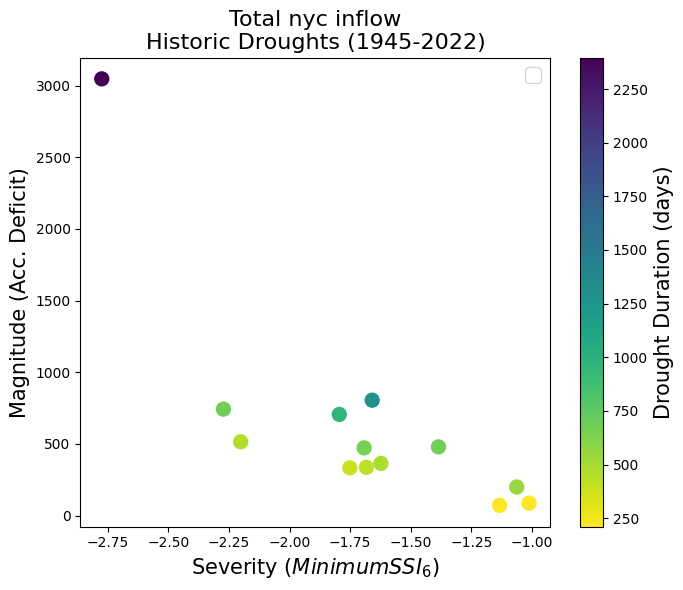

In [90]:
## Options
highlight_after_1970 = False

fig, ax = plt.subplots(figsize = (7,6))
# cmap = plt.get_cmap('Reds')
# norm = mpl.colors.Normalize(vmin=drought_metrics['severity'].min(), 
#                             vmax=drought_metrics['severity'].max())

# cs = cmap(norm(drought_metrics['severity'].values))
p = ax.scatter(drought_metrics['severity'], -drought_metrics['magnitude'],
           c= drought_metrics['duration'], cmap = 'viridis_r', s=100)

if highlight_after_1970:
    ax.scatter(drought_metrics.loc[drought_metrics['start'] > pd.to_datetime('1970-01-01'), 'severity'], 
               -drought_metrics.loc[drought_metrics['start'] > pd.to_datetime('1970-01-01'), 'magnitude'],
           edgecolors = 'darkorange', s=300, facecolors='none', linewidths=3,
           label = 'Droughts observed after 1970')


plt.colorbar(p).set_label(label = 'Drought Duration (days)',size=15)
plt.xlabel(r'Severity ($Minimum SSI_{6}$)', fontsize = 15)
plt.ylabel(r'Magnitude (Acc. Deficit)', fontsize = 15)
plt.title(f'{plot_nodes[0].capitalize()}\nHistoric Droughts (1945-2022)', fontsize = 16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# plt.yscale('log')
# plt.xscale('log')

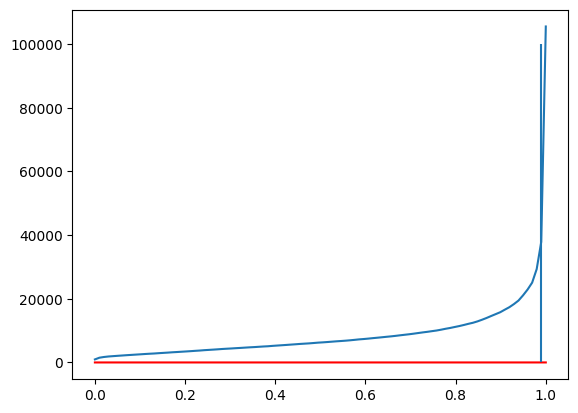

In [65]:
qs  = [0.0003, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.995, 0.9997]
qs = np.linspace(0.0001, 0.99999, 100)
fdc = np.quantile(Q_reconst['delTrenton'], qs)
pfdc = np.log(np.quantile(Q_reconst['delTrenton'], qs))
plt.plot(qs, fdc)
plt.plot(qs, pfdc, c='red')
plt.vlines(0.99, 0, 100000)
# plt.yscale('log')

<Axes: >

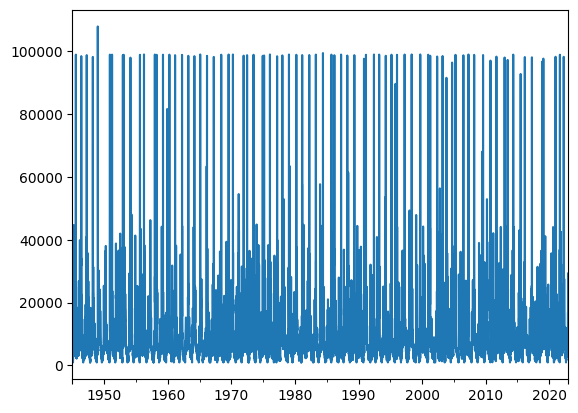

In [63]:
Q_reconst_nodes['delTrenton'].plot()

plt.yscale('log')

In [33]:
import pandas as pd

pd.Series(fdc, index = qs)

0.0003      924.315730
0.0050     1310.655414
0.0500     2081.882042
0.1000     2562.607265
0.2000     3452.519045
0.3000     4394.735878
0.4000     5278.839264
0.5000     6274.265953
0.6000     7390.885713
0.7000     8901.993596
0.8000    11183.019122
0.9000    15860.656338
0.9300    18459.637120
0.9500    21170.206131
0.9700    25078.920137
0.9950    46859.006510
0.9997    83823.386721
dtype: float64